In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

from toss import compute_trajectory
from toss import compute_motion, setup_spin_axis
from toss import get_trajectory_fixed_step
from toss import FitnessFunctions
from toss import get_fitness
from toss import create_mesh
from toss import estimate_covered_volume

from dotmap import DotMap
import numpy as np
from math import pi
import matplotlib.pyplot as plt 
import pykep as pk

Using numpy backend


In [3]:

def get_parameters():
    """Returns parameters used by compute trajectory and fitness functions.

    Returns:
        args (dotmap.Dotmap): Dotmap with parameters used for the tests.
    """
    args = DotMap(
        body = DotMap(_dynamic=False),
        integrator = DotMap(_dynamic=False),
        problem = DotMap(_dynamic=False),
        mesh = DotMap(_dynamic=False),
        _dynamic=False)

    # Setup body parameters
    args.body.density = 533                  # https://sci.esa.int/web/rosetta/-/14615-comet-67p
    args.body.mu = 665.666                   # Gravitational parameter for 67P/C-G
    args.body.declination = 64               # [degrees] https://sci.esa.int/web/rosetta/-/14615-comet-67p
    args.body.right_ascension = 69           # [degrees] https://sci.esa.int/web/rosetta/-/14615-comet-67p
    args.body.spin_period = 12.06*3600       # [seconds] https://sci.esa.int/web/rosetta/-/14615-comet-67p
    args.body.spin_velocity = (2*pi)/args.body.spin_period
    args.body.spin_axis = setup_spin_axis(args)

    # Setup specific integrator parameters:
    args.integrator.algorithm = 3
    args.integrator.dense_output = True
    args.integrator.rtol = 1e-12
    args.integrator.atol = 1e-12

    # Setup problem parameters
    args.problem.start_time = 0                     # Starting time [s]
    args.problem.final_time = 20*3600.0             # Final time [s]
    args.problem.initial_time_step = 600            # Initial time step size for integration [s]
    args.problem.activate_event = True              # Event configuration (0 = no event, 1 = collision with body detection)
    args.problem.number_of_maneuvers = 0 
    args.problem.target_squared_altitude = 8000**2  # Target altitude squared [m]
    args.problem.activate_rotation = False

    # Arguments concerning bounding spheres
    args.problem.measurement_period = 1000                # Period for when a measurement sphere is recognized and managed. Unit: [seconds]
    args.problem.radius_inner_bounding_sphere = 4000      # Radius of spherical risk-zone for collision with celestial body [m]
    args.problem.radius_outer_bounding_sphere = 10000
    args.problem.squared_volume_inner_bounding_sphere = (4/3) * pi * (args.problem.radius_inner_bounding_sphere**3)
    args.problem.squared_volume_outer_bounding_sphere = (4/3) * pi * (args.problem.radius_outer_bounding_sphere**3)
    args.problem.total_measurable_volume = args.problem.squared_volume_outer_bounding_sphere - args.problem.squared_volume_inner_bounding_sphere

    # Create mesh of body.
    args.mesh.body, args.mesh.vertices, args.mesh.faces, args.mesh.largest_body_protuberant = create_mesh()

    return args

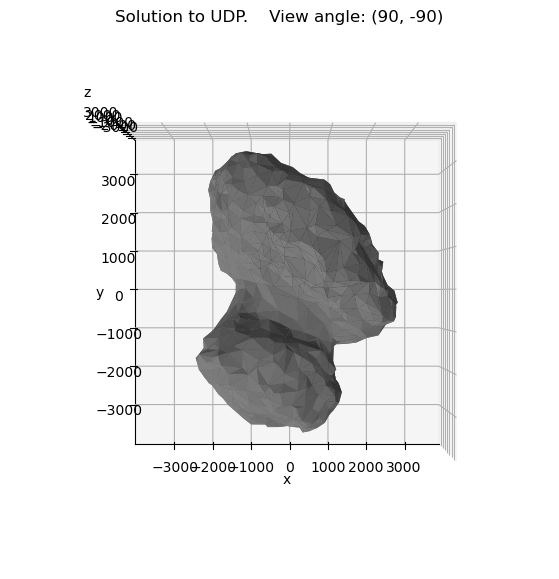

In [5]:
# Plot mesh to localize point of -assumably- greatest acceleration
from toss import plot_UDP
args = get_parameters()
plot_UDP(args, None, True, False, False, False, [90,-90], None)

# Results:   [x,y,z] = [4000, 0, 0]

In [10]:

# Fine tune mission parameters
args.problem.start_time = 0          
args.problem.final_time = 30000      
args.problem.initial_time_step = 1      
args.problem.measurement_period = 100     

# Assign initial velocity
x = np.empty(6, dtype=np.float64)
x[0:3] = [0, 4000, 0]
x[3:6] = [0.72, 0.01, 0.01] # velocity that works: [0.44, 0.35, 0.4]

# Convert to osculating elements
x = pk.ic2par(r=x[0:3], v=x[3:6], mu=args.body.mu)
print(x)

# Compute trajectory
collision_detected, list_of_ode_pbjects, _ = compute_trajectory(x, args, compute_motion)
positions, velocities, timesteps = get_trajectory_fixed_step(args, list_of_ode_pbjects)
print(collision_detected)

(3583.338267830132, 2.1161190471089517, 3.127704657658826, 1.5707963267948966, 6.2627364911561045, 0.012238441608417487)
False


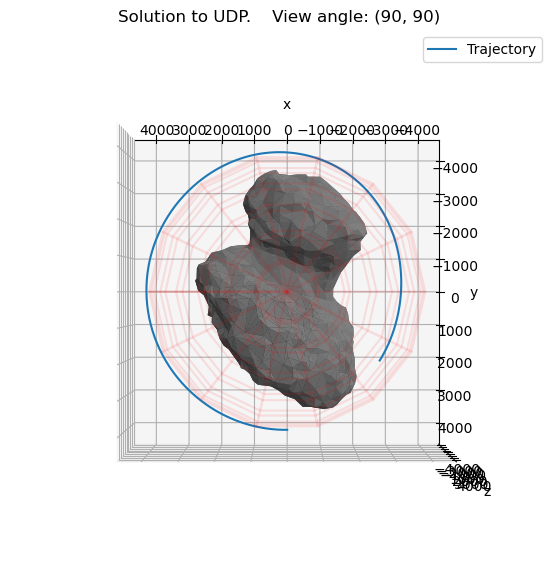

In [11]:
plot_UDP(args, positions, True, True, True, False, [90,90], None)

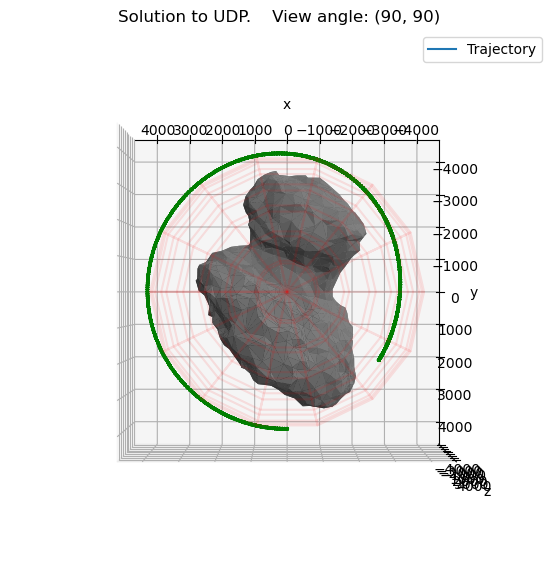

In [249]:
#positions = np.transpose(list_of_ode_pbjects[0].y[:,0:3])
#velocities = np.transpose(list_of_ode_pbjects[0].y[:,3:6])
#print(positions[:,0:10])
#print(velocities[:,0:10])


radii_spheres, estimated_volume = estimate_covered_volume(positions)
plot_UDP(args, positions, True, True, True, True, [90,90], radii_spheres)


In [250]:
print(radii_spheres)

[35.95398913 35.95398913 35.85006771 35.74738601 35.64631702 35.54674906
 35.44849599 35.35205081 35.2572796  35.16391313 35.07229585 34.9824889
 34.89420594 34.80739654 34.72242629 34.63915417 34.55734108 34.47694815
 34.39830439 34.32130113 34.24574046 34.17147621 34.09875294 34.02763327
 33.95795437 33.88955711 33.82240348 33.75674465 33.69252571 33.62961248
 33.56787673 33.50732474 33.44816098 33.3903197  33.33369132 33.27817163
 33.22375718 33.17062655 33.11873377 33.06798906 33.01830773 32.9696509
 32.92217009 32.87586722 32.83066863 32.78650548 32.74331629 32.70115288
 32.66011111 32.62014192 32.58118904 32.54320103 32.50613474 32.47004338
 32.43498437 32.40091588 32.36779568 32.33558636 32.30425531 32.27380612
 32.2442933  32.21569454 32.18797737 32.16111414 32.13508198 32.10986288
 32.08545327 32.06186752 32.03907916 32.0170648  31.99580613 31.97528981
 31.95550741 31.93645547 31.91812486 31.90047002 31.88346431 31.86709384
 31.85134981 31.83622856 31.82173156 31.80786469 31.7